# Importing Libraries

In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import load_npz
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split, DataLoader, TensorDataset

# Importing Data

In [2]:
tweets_tfidf = load_npz("../Data/Text/TF-IDF/captions.npz")
tweets_bert = np.load("../Data/Text/BERT/captions.npy")
EfficientNet = np.load("../Data/Images/Image Embeddings/EfficientNet.npy")
DenseNet = np.load("../Data/Images/Image Embeddings/densenet.npy")
DenseNet = np.squeeze(DenseNet, axis=1)
y = np.load("../Data/Text/TF-IDF/labels.npy")

In [3]:
bert_efficientnet = np.hstack([tweets_bert, EfficientNet])
tfidf_efficientnet = np.hstack([tweets_tfidf.toarray(), EfficientNet])
bert_densenet = np.hstack([tweets_bert, DenseNet])
tfidf_densenet = np.hstack([tweets_tfidf.toarray(), DenseNet])

In [4]:
y = OneHotEncoder(sparse_output=False).fit_transform(y.reshape(-1,1))
y.shape

(4869, 3)

# Model Architecture

In [27]:
class Model01_bert_eff(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(2048, 1024),
            torch.nn.SELU(),
            torch.nn.Linear(1024, 512),
            torch.nn.SELU(),
            torch.nn.Linear(512, 256),
            torch.nn.SELU(),
            torch.nn.Linear(256, 3)
        )

        for layer in self.model:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(layer.weight)

    def forward(self, x):
        return self.model(x)

In [6]:
x = torch.from_numpy(bert_efficientnet).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [7]:
dataset_bert_eff = TensorDataset(x,y)
train_size = int(0.7 * len(dataset_bert_eff))
test_size = int(0.2*len(dataset_bert_eff))
val_size = len(dataset_bert_eff) - train_size - test_size
train_set, test_set, val_set = random_split(dataset_bert_eff, [train_size, test_size, val_size])

train_loader = DataLoader(train_set, 32, True)
test_loader = DataLoader(test_set, 32, True)
val_loader = DataLoader(val_set, 32, True)

In [28]:
model = Model01_bert_eff()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

In [18]:
from torchsummary import summary
model.to("cuda")
summary(model, (1, 2048))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]       2,098,176
              SELU-2              [-1, 1, 1024]               0
            Linear-3               [-1, 1, 512]         524,800
              SELU-4               [-1, 1, 512]               0
            Linear-5               [-1, 1, 256]         131,328
              SELU-6               [-1, 1, 256]               0
            Linear-7                 [-1, 1, 3]             771
Total params: 2,755,075
Trainable params: 2,755,075
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 10.51
Estimated Total Size (MB): 10.54
----------------------------------------------------------------


In [36]:
best_val_loss = float('inf')
epochs_without_improvement = 0
total_train_loss = []
total_val_loss = []
best_model_weights = model.state_dict()
model.to("cuda")
for epoch in tqdm(range(50)):
    model.train()
    print(f"Epoch : {epoch}\n----------------------")
    train_loss = 0
    for batch, (x,y) in enumerate(train_loader):
        x, y = x.to("cuda"), y.to("cuda")
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        print(f"Loss for batch: {batch} = {loss}")
        train_loss += loss

    print("\nTraining Loss for epoch {} = {}\n".format(epoch, train_loss))
    total_train_loss.append(train_loss/len(train_loader.dataset))

    model.eval()
    validation_loss = 0
    with torch.inference_mode():
        for x,y in val_loader:
            x,y = x.to("cuda"), y.to("cuda")
            outputs = model(x)
            loss = criterion(outputs, y)
            validation_loss+=loss

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            epochs_without_improvement = 0
            best_model_weights = model.state_dict()
        else:
            epochs_without_improvement+=1

        print(f"Current Validation Loss = {validation_loss}")
        print(f"Best Validation Loss = {best_val_loss}")
        print(f"Epochs without Improvement = {epochs_without_improvement}")

    total_val_loss.append(validation_loss/len(val_loader.dataset))
    if epochs_without_improvement >= 10:
        print("Early Stoppping Triggered")
        break

# model.load_state_dict(best_model_weights)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 0
----------------------
Loss for batch: 0 = 0.16510362923145294
Loss for batch: 1 = 0.1815323531627655
Loss for batch: 2 = 0.25004953145980835
Loss for batch: 3 = 0.24825891852378845
Loss for batch: 4 = 0.35715755820274353
Loss for batch: 5 = 0.29252269864082336
Loss for batch: 6 = 0.12436291575431824
Loss for batch: 7 = 0.21199136972427368
Loss for batch: 8 = 0.2951031029224396
Loss for batch: 9 = 0.2718105912208557
Loss for batch: 10 = 0.2768493890762329
Loss for batch: 11 = 0.1324886679649353
Loss for batch: 12 = 0.16855637729167938
Loss for batch: 13 = 0.34600186347961426
Loss for batch: 14 = 0.14948579668998718
Loss for batch: 15 = 0.1653413623571396
Loss for batch: 16 = 0.27836960554122925
Loss for batch: 17 = 0.16349713504314423
Loss for batch: 18 = 0.15971356630325317
Loss for batch: 19 = 0.29361850023269653
Loss for batch: 20 = 0.1472408026456833
Loss for batch: 21 = 0.34642142057418823
Loss for batch: 22 = 0.21201108396053314
Loss for batch: 23 = 0.2578083872795105
L

  2%|▏         | 1/50 [00:00<00:42,  1.15it/s]

Epoch : 1
----------------------
Loss for batch: 0 = 0.43679746985435486
Loss for batch: 1 = 0.33996373414993286
Loss for batch: 2 = 0.32471832633018494
Loss for batch: 3 = 0.5458394289016724
Loss for batch: 4 = 0.9429407119750977
Loss for batch: 5 = 0.25562068819999695
Loss for batch: 6 = 0.25737106800079346
Loss for batch: 7 = 0.2225121706724167
Loss for batch: 8 = 0.28715047240257263
Loss for batch: 9 = 0.11325522512197495
Loss for batch: 10 = 0.18216297030448914
Loss for batch: 11 = 0.12377022206783295
Loss for batch: 12 = 0.21989071369171143
Loss for batch: 13 = 0.17333540320396423
Loss for batch: 14 = 0.13166514039039612
Loss for batch: 15 = 0.2821546196937561
Loss for batch: 16 = 0.2561570107936859
Loss for batch: 17 = 0.20859217643737793
Loss for batch: 18 = 0.1429685652256012
Loss for batch: 19 = 0.1838344782590866
Loss for batch: 20 = 0.15666206181049347
Loss for batch: 21 = 0.11295008659362793
Loss for batch: 22 = 0.148330420255661
Loss for batch: 23 = 0.09682852029800415
Lo

  4%|▍         | 2/50 [00:01<00:36,  1.32it/s]

Loss for batch: 105 = 0.2905783951282501
Loss for batch: 106 = 0.32832321524620056

Training Loss for epoch 1 = 24.0587215423584

Current Validation Loss = 15.77910041809082
Best Validation Loss = 15.77910041809082
Epochs without Improvement = 0
Epoch : 2
----------------------
Loss for batch: 0 = 0.08063609898090363
Loss for batch: 1 = 0.09495377540588379
Loss for batch: 2 = 0.15742838382720947
Loss for batch: 3 = 0.11323980987071991
Loss for batch: 4 = 0.09009574353694916
Loss for batch: 5 = 0.13801951706409454
Loss for batch: 6 = 0.07868731766939163
Loss for batch: 7 = 0.10021860897541046
Loss for batch: 8 = 0.12226293981075287
Loss for batch: 9 = 0.13276687264442444
Loss for batch: 10 = 0.09520523250102997
Loss for batch: 11 = 0.1266527771949768
Loss for batch: 12 = 0.2730567455291748
Loss for batch: 13 = 0.40013188123703003
Loss for batch: 14 = 0.1914074867963791
Loss for batch: 15 = 0.1970391720533371
Loss for batch: 16 = 0.11657094955444336
Loss for batch: 17 = 0.231030151247978

  6%|▌         | 3/50 [00:02<00:33,  1.39it/s]

Loss for batch: 94 = 0.21434542536735535
Loss for batch: 95 = 0.044514529407024384
Loss for batch: 96 = 0.09577655792236328
Loss for batch: 97 = 0.1606481969356537
Loss for batch: 98 = 0.1874389350414276
Loss for batch: 99 = 0.21058712899684906
Loss for batch: 100 = 0.44434303045272827
Loss for batch: 101 = 0.7268588542938232
Loss for batch: 102 = 0.29041752219200134
Loss for batch: 103 = 0.14556364715099335
Loss for batch: 104 = 0.091647207736969
Loss for batch: 105 = 0.1960747241973877
Loss for batch: 106 = 0.025669675320386887

Training Loss for epoch 2 = 19.85262680053711

Current Validation Loss = 16.479522705078125
Best Validation Loss = 15.77910041809082
Epochs without Improvement = 1
Epoch : 3
----------------------
Loss for batch: 0 = 0.1283120959997177
Loss for batch: 1 = 0.09565150737762451
Loss for batch: 2 = 0.14328795671463013
Loss for batch: 3 = 0.034172654151916504
Loss for batch: 4 = 0.18578529357910156
Loss for batch: 5 = 0.1703205108642578
Loss for batch: 6 = 0.07611

  8%|▊         | 4/50 [00:02<00:32,  1.43it/s]

Loss for batch: 89 = 0.1854497194290161
Loss for batch: 90 = 0.2706308364868164
Loss for batch: 91 = 0.09032183885574341
Loss for batch: 92 = 0.14713987708091736
Loss for batch: 93 = 0.08365463465452194
Loss for batch: 94 = 0.09052613377571106
Loss for batch: 95 = 0.11844419687986374
Loss for batch: 96 = 0.17908482253551483
Loss for batch: 97 = 0.07003109902143478
Loss for batch: 98 = 0.10591845959424973
Loss for batch: 99 = 0.048052676022052765
Loss for batch: 100 = 0.037276025861501694
Loss for batch: 101 = 0.060804933309555054
Loss for batch: 102 = 0.22055888175964355
Loss for batch: 103 = 0.1966637372970581
Loss for batch: 104 = 0.16912393271923065
Loss for batch: 105 = 0.18120837211608887
Loss for batch: 106 = 0.09776651859283447

Training Loss for epoch 3 = 14.430496215820312

Current Validation Loss = 21.48734474182129
Best Validation Loss = 15.77910041809082
Epochs without Improvement = 2
Epoch : 4
----------------------
Loss for batch: 0 = 0.03813524544239044
Loss for batch: 1

 10%|█         | 5/50 [00:03<00:30,  1.46it/s]

Loss for batch: 86 = 0.03999333083629608
Loss for batch: 87 = 0.15676003694534302
Loss for batch: 88 = 0.13397574424743652
Loss for batch: 89 = 0.07885976880788803
Loss for batch: 90 = 0.12170401215553284
Loss for batch: 91 = 0.07206914573907852
Loss for batch: 92 = 0.11849038302898407
Loss for batch: 93 = 0.3461650311946869
Loss for batch: 94 = 0.20113776624202728
Loss for batch: 95 = 0.09905613958835602
Loss for batch: 96 = 0.21386754512786865
Loss for batch: 97 = 0.174710214138031
Loss for batch: 98 = 0.274278461933136
Loss for batch: 99 = 0.18814346194267273
Loss for batch: 100 = 0.12245812267065048
Loss for batch: 101 = 0.05789395421743393
Loss for batch: 102 = 0.026436910033226013
Loss for batch: 103 = 0.0639922022819519
Loss for batch: 104 = 0.055550359189510345
Loss for batch: 105 = 0.14493918418884277
Loss for batch: 106 = 0.029643550515174866

Training Loss for epoch 4 = 15.5729341506958

Current Validation Loss = 19.696487426757812
Best Validation Loss = 15.77910041809082
Ep

 12%|█▏        | 6/50 [00:04<00:29,  1.47it/s]

Loss for batch: 82 = 0.17901670932769775
Loss for batch: 83 = 0.12905848026275635
Loss for batch: 84 = 0.10307067632675171
Loss for batch: 85 = 0.10299666970968246
Loss for batch: 86 = 0.12243771553039551
Loss for batch: 87 = 0.06134437769651413
Loss for batch: 88 = 0.07576120644807816
Loss for batch: 89 = 0.14296561479568481
Loss for batch: 90 = 0.07902342081069946
Loss for batch: 91 = 0.2565266788005829
Loss for batch: 92 = 0.41095656156539917
Loss for batch: 93 = 0.3212074637413025
Loss for batch: 94 = 0.44206738471984863
Loss for batch: 95 = 0.19339267909526825
Loss for batch: 96 = 0.11088995635509491
Loss for batch: 97 = 0.07679824531078339
Loss for batch: 98 = 0.19947358965873718
Loss for batch: 99 = 0.1831795871257782
Loss for batch: 100 = 0.23917941749095917
Loss for batch: 101 = 0.08859628438949585
Loss for batch: 102 = 0.34390968084335327
Loss for batch: 103 = 0.1312209665775299
Loss for batch: 104 = 0.12752851843833923
Loss for batch: 105 = 0.09780947864055634
Loss for batch

 14%|█▍        | 7/50 [00:04<00:29,  1.47it/s]

Epoch : 7
----------------------
Loss for batch: 0 = 0.16250011324882507
Loss for batch: 1 = 0.06626918166875839
Loss for batch: 2 = 0.023615708574652672
Loss for batch: 3 = 0.11458858102560043
Loss for batch: 4 = 0.12645679712295532
Loss for batch: 5 = 0.0462816022336483
Loss for batch: 6 = 0.0669855922460556
Loss for batch: 7 = 0.05859294533729553
Loss for batch: 8 = 0.045108404010534286
Loss for batch: 9 = 0.11311481893062592
Loss for batch: 10 = 0.021454088389873505
Loss for batch: 11 = 0.2536334693431854
Loss for batch: 12 = 0.044521182775497437
Loss for batch: 13 = 0.06983977556228638
Loss for batch: 14 = 0.044312864542007446
Loss for batch: 15 = 0.05674610659480095
Loss for batch: 16 = 0.03245308995246887
Loss for batch: 17 = 0.03629111871123314
Loss for batch: 18 = 0.026814958080649376
Loss for batch: 19 = 0.04673457890748978
Loss for batch: 20 = 0.06054137274622917
Loss for batch: 21 = 0.035101067274808884
Loss for batch: 22 = 0.07081745564937592
Loss for batch: 23 = 0.0293936

 16%|█▌        | 8/50 [00:05<00:28,  1.48it/s]

Loss for batch: 105 = 0.15595096349716187
Loss for batch: 106 = 0.07889905571937561

Training Loss for epoch 7 = 7.964679718017578

Current Validation Loss = 24.39595603942871
Best Validation Loss = 15.77910041809082
Epochs without Improvement = 6
Epoch : 8
----------------------
Loss for batch: 0 = 0.03323990851640701
Loss for batch: 1 = 0.07577000558376312
Loss for batch: 2 = 0.08577436208724976
Loss for batch: 3 = 0.05366399511694908
Loss for batch: 4 = 0.06097172945737839
Loss for batch: 5 = 0.04034486413002014
Loss for batch: 6 = 0.0023456790950149298
Loss for batch: 7 = 0.017205309122800827
Loss for batch: 8 = 0.23152169585227966
Loss for batch: 9 = 0.08329544961452484
Loss for batch: 10 = 0.08371048420667648
Loss for batch: 11 = 0.02858499065041542
Loss for batch: 12 = 0.04029606282711029
Loss for batch: 13 = 0.04076554253697395
Loss for batch: 14 = 0.012213698588311672
Loss for batch: 15 = 0.013024982064962387
Loss for batch: 16 = 0.055250994861125946
Loss for batch: 17 = 0.024

 18%|█▊        | 9/50 [00:06<00:27,  1.49it/s]

Loss for batch: 101 = 0.010850060731172562
Loss for batch: 102 = 0.13807463645935059
Loss for batch: 103 = 0.04458640143275261
Loss for batch: 104 = 0.13463808596134186
Loss for batch: 105 = 0.08359362930059433
Loss for batch: 106 = 0.2524615228176117

Training Loss for epoch 8 = 12.237785339355469

Current Validation Loss = 23.837173461914062
Best Validation Loss = 15.77910041809082
Epochs without Improvement = 7
Epoch : 9
----------------------
Loss for batch: 0 = 0.13706544041633606
Loss for batch: 1 = 0.01659512333571911
Loss for batch: 2 = 0.03912167623639107
Loss for batch: 3 = 0.08617568016052246
Loss for batch: 4 = 0.12312889099121094
Loss for batch: 5 = 0.03517026826739311
Loss for batch: 6 = 0.09112583100795746
Loss for batch: 7 = 0.04767683893442154
Loss for batch: 8 = 0.06253445893526077
Loss for batch: 9 = 0.08500417321920395
Loss for batch: 10 = 0.07323049753904343
Loss for batch: 11 = 0.031243961304426193
Loss for batch: 12 = 0.1272439807653427
Loss for batch: 13 = 0.231

 20%|██        | 10/50 [00:06<00:26,  1.49it/s]

Loss for batch: 95 = 0.013391698710620403
Loss for batch: 96 = 0.024393483996391296
Loss for batch: 97 = 0.03681925684213638
Loss for batch: 98 = 0.04686897248029709
Loss for batch: 99 = 0.03862439841032028
Loss for batch: 100 = 0.0324954017996788
Loss for batch: 101 = 0.07265356183052063
Loss for batch: 102 = 0.01151801086962223
Loss for batch: 103 = 0.07569149136543274
Loss for batch: 104 = 0.053056955337524414
Loss for batch: 105 = 0.08973926305770874
Loss for batch: 106 = 0.13830213248729706

Training Loss for epoch 9 = 6.889788627624512

Current Validation Loss = 26.52515411376953
Best Validation Loss = 15.77910041809082
Epochs without Improvement = 8
Epoch : 10
----------------------
Loss for batch: 0 = 0.0986524447798729
Loss for batch: 1 = 0.04826497286558151
Loss for batch: 2 = 0.012993909418582916
Loss for batch: 3 = 0.01958363503217697
Loss for batch: 4 = 0.023198461160063744
Loss for batch: 5 = 0.12894117832183838
Loss for batch: 6 = 0.030048003420233727
Loss for batch: 7 =

 22%|██▏       | 11/50 [00:07<00:26,  1.49it/s]

Loss for batch: 94 = 0.06202935799956322
Loss for batch: 95 = 0.07709059119224548
Loss for batch: 96 = 0.04608812928199768
Loss for batch: 97 = 0.05765935406088829
Loss for batch: 98 = 0.04111674427986145
Loss for batch: 99 = 0.049062579870224
Loss for batch: 100 = 0.0026500881649553776
Loss for batch: 101 = 0.003879975061863661
Loss for batch: 102 = 0.014771517366170883
Loss for batch: 103 = 0.020314618945121765
Loss for batch: 104 = 0.05576393008232117
Loss for batch: 105 = 0.01518828235566616
Loss for batch: 106 = 0.015299986116588116

Training Loss for epoch 10 = 4.784097194671631

Current Validation Loss = 24.941267013549805
Best Validation Loss = 15.77910041809082
Epochs without Improvement = 9
Epoch : 11
----------------------
Loss for batch: 0 = 0.012010614387691021
Loss for batch: 1 = 0.09333281964063644
Loss for batch: 2 = 0.1904304325580597
Loss for batch: 3 = 0.02130088210105896
Loss for batch: 4 = 0.04855386167764664
Loss for batch: 5 = 0.03576979041099548
Loss for batch: 

 22%|██▏       | 11/50 [00:08<00:29,  1.33it/s]

Loss for batch: 85 = 0.002214370295405388
Loss for batch: 86 = 0.038589369505643845
Loss for batch: 87 = 0.025360098108649254
Loss for batch: 88 = 0.029356643557548523
Loss for batch: 89 = 0.057436566799879074
Loss for batch: 90 = 0.01017427071928978
Loss for batch: 91 = 0.006005163304507732
Loss for batch: 92 = 0.04359331354498863
Loss for batch: 93 = 0.006033105310052633
Loss for batch: 94 = 0.050317443907260895
Loss for batch: 95 = 0.02899501845240593
Loss for batch: 96 = 0.021943524479866028
Loss for batch: 97 = 0.04002695530653
Loss for batch: 98 = 0.007274298928678036
Loss for batch: 99 = 0.043344080448150635
Loss for batch: 100 = 0.014854892157018185
Loss for batch: 101 = 0.07208295166492462
Loss for batch: 102 = 0.05634059011936188
Loss for batch: 103 = 0.033085472881793976
Loss for batch: 104 = 0.04262159392237663
Loss for batch: 105 = 0.008665496483445168
Loss for batch: 106 = 0.017255373299121857

Training Loss for epoch 11 = 4.629846096038818

Current Validation Loss = 29.6

In [12]:
from sklearn.metrics import accuracy_score
def TrainLoopv2(
    model,
    optimizer:torch.optim.Optimizer,
    criterion:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    val_dataloader:torch.utils.data.DataLoader,
    test_dataloader:torch.utils.data.DataLoader=None,
    num_epochs:int=20,
    early_stopping_rounds:int=5,
    return_best_model:bool=True,
    device:str='cpu'
):
    """
    Train a PyTorch model using the provided data loaders and monitor training progress.

    Args:
        model (torch.nn.Module): The PyTorch model to train.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        criterion (torch.nn.Module): The loss function to optimize.
        train_dataloader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_dataloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        test_dataloader (torch.utils.data.DataLoader, optional): DataLoader for the test dataset (default: None).
        num_epochs (int, optional): Number of training epochs (default: 20).
        early_stopping_rounds (int, optional): Number of epochs to wait for improvement in validation loss
            before early stopping (default: 5).
        return_best_model (bool, optional): Whether to return the model with the best validation loss (default: True).
        device (str, optional): Device to use for training ('cpu' or 'cuda') (default: 'cpu').

    Returns:
        None or torch.nn.Module: If return_best_model is True, returns the trained model with the best validation loss;
        otherwise, returns None.

    Note:
        This function monitors training and validation loss and accuracy over epochs and can optionally
        plot the loss and accuracy curves.

    Example:
        See the code example provided for usage.
    """
    model.to(device)
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    total_train_loss = []
    total_val_loss = []
    total_test_loss = []
    best_model_weights = model.state_dict()

    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        print("\nEpoch {}\n----------".format(epoch))
        train_loss = 0
        for i, (batch, label) in enumerate(train_dataloader):
            batch, label = batch.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, label.float())
            train_loss += loss
            loss.backward()
            optimizer.step()
            print("Loss for batch {} = {}".format(i, loss))

        print("\nTraining Loss for epoch {} = {}\n".format(epoch, train_loss))
        total_train_loss.append(train_loss/len(train_dataloader.dataset))

        model.eval()
        validation_loss = 0
        with torch.inference_mode():
            val_true_labels = []
            train_true_labels = []
            val_pred_labels = []
            train_pred_labels = []
            for batch, label in val_dataloader:
                batch, label = batch.to(device), label.to(device)
                outputs = model(batch)
                loss = criterion(outputs, label.float())
                validation_loss += loss

                outputs = torch.round(torch.sigmoid(outputs))
                val_true_labels.extend(label.cpu().numpy())
                val_pred_labels.extend(outputs.cpu().numpy())

            for batch, label in train_dataloader:
                batch, label = batch.to(device), label.to(device)
                outputs = model(batch)

                outputs = torch.round(torch.sigmoid(outputs))
                train_true_labels.extend(label.cpu().numpy())
                train_pred_labels.extend(outputs.cpu().numpy())

            if validation_loss < best_val_loss:
                best_val_loss = validation_loss
                epochs_without_improvement = 0
                best_model_weights = model.state_dict()
            else:
                epochs_without_improvement += 1

            val_true_labels = np.array(val_true_labels)
            train_true_labels = np.array(train_true_labels)
            val_pred_labels = np.array(val_pred_labels)
            train_pred_labels = np.array(train_pred_labels)

            train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
            val_accuracy = accuracy_score(val_true_labels, val_pred_labels)

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            print(f"Current Validation Loss = {validation_loss}")
            print(f"Best Validation Loss = {best_val_loss}")
            print(f"Epochs without Improvement = {epochs_without_improvement}")

            print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
            print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

        total_val_loss.append(validation_loss/len(val_dataloader.dataset))

        if test_dataloader is not None:
            test_loss = 0
            with torch.inference_mode():
                for batch, label in test_dataloader:
                    batch, label = batch.to(device), label.to(device)
                    outputs = model(batch)
                    loss = criterion(outputs, label.float())
                    test_loss += loss

                print("\nTest Loss for epoch {} = {}\n".format(epoch, test_loss))
            total_test_loss.append(test_loss/len(test_dataloader.dataset))

        if epochs_without_improvement >= early_stopping_rounds:
            print("Early Stoppping Triggered")
            break

    if return_best_model == True:
        model.load_state_dict(best_model_weights)
    total_train_loss = [item.cpu().detach().numpy() for item in total_train_loss]
    total_val_loss = [item.cpu().detach().numpy() for item in total_val_loss]

    total_train_loss = np.array(total_train_loss)
    total_val_loss = np.array(total_val_loss)

    train_accuracies = np.array(train_accuracies)
    val_accuracies = np.array(val_accuracies)

    x_train = np.arange(len(total_train_loss))
    x_val = np.arange(len(total_val_loss))
    
    sns.set_style('whitegrid')
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    try:
        total_test_loss = [item.cpu().detach().numpy() for item in total_test_loss]
        total_test_loss = np.array(total_test_loss)
        x_test = np.arange(len(total_test_loss))
        sns.lineplot(x=x_test, y=total_test_loss, label='Testing Loss')
    except:
        pass

    sns.lineplot(x=x_train, y=total_train_loss, label='Training Loss')
    sns.lineplot(x=x_val, y=total_val_loss, label='Validation Loss')
    plt.title("Loss over {} Epochs".format(len(total_train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(np.arange(len(total_train_loss)))
    
    plt.subplot(1,2,2)
    sns.lineplot(x=x_train, y=train_accuracies, label='Training Accuracy')
    sns.lineplot(x=x_val, y=val_accuracies, label='Validation Accuracy')
    plt.title("Accuracy over {} Epochs".format(len(total_train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(np.arange(len(total_train_loss)))

    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 1.014578104019165
Loss for batch 1 = 5.19977331161499
Loss for batch 2 = 1.5508254766464233
Loss for batch 3 = 3.372941017150879
Loss for batch 4 = 4.161283493041992
Loss for batch 5 = 1.3018360137939453
Loss for batch 6 = 1.601271152496338
Loss for batch 7 = 1.0607154369354248
Loss for batch 8 = 1.0760916471481323
Loss for batch 9 = 1.5593236684799194
Loss for batch 10 = 1.9911893606185913
Loss for batch 11 = 1.4221689701080322
Loss for batch 12 = 0.6035967469215393
Loss for batch 13 = 0.6954449415206909
Loss for batch 14 = 0.719988226890564
Loss for batch 15 = 0.7601801753044128
Loss for batch 16 = 0.5828694701194763
Loss for batch 17 = 0.6983851194381714
Loss for batch 18 = 0.9198417067527771
Loss for batch 19 = 0.7893872261047363
Loss for batch 20 = 0.8139294385910034
Loss for batch 21 = 0.9181838035583496
Loss for batch 22 = 0.9654979705810547
Loss for batch 23 = 0.8743981719017029
Loss for batch 24 = 0.5406288504600525
Loss for batch 25 = 0.

  2%|▏         | 1/50 [00:00<00:48,  1.01it/s]

Current Validation Loss = 13.568245887756348
Best Validation Loss = 13.568245887756348
Epochs without Improvement = 0
Train Accuracy: 39.00%
Validation Accuracy: 32.17%

Epoch 1
----------
Loss for batch 0 = 0.6224752068519592
Loss for batch 1 = 0.5158944129943848
Loss for batch 2 = 0.511666476726532
Loss for batch 3 = 0.4529153108596802
Loss for batch 4 = 0.471196711063385
Loss for batch 5 = 0.49165672063827515
Loss for batch 6 = 0.5233616232872009
Loss for batch 7 = 0.6138163805007935
Loss for batch 8 = 0.5104269981384277
Loss for batch 9 = 0.410862535238266
Loss for batch 10 = 0.6461741924285889
Loss for batch 11 = 0.6865035891532898
Loss for batch 12 = 0.5346152782440186
Loss for batch 13 = 0.48199009895324707
Loss for batch 14 = 0.4166538715362549
Loss for batch 15 = 0.4026637077331543
Loss for batch 16 = 0.39624613523483276
Loss for batch 17 = 0.4803256392478943
Loss for batch 18 = 0.4373602271080017
Loss for batch 19 = 0.5597971081733704
Loss for batch 20 = 0.6041118502616882
Lo

  4%|▍         | 2/50 [00:01<00:41,  1.16it/s]

Current Validation Loss = 9.587371826171875
Best Validation Loss = 9.587371826171875
Epochs without Improvement = 0
Train Accuracy: 61.24%
Validation Accuracy: 41.60%

Epoch 2
----------
Loss for batch 0 = 0.42861220240592957
Loss for batch 1 = 0.33986586332321167
Loss for batch 2 = 0.3351646661758423
Loss for batch 3 = 0.3220907747745514
Loss for batch 4 = 0.3239196538925171
Loss for batch 5 = 0.3844642639160156
Loss for batch 6 = 0.3552582263946533
Loss for batch 7 = 0.31061673164367676
Loss for batch 8 = 0.2647508978843689
Loss for batch 9 = 0.30426493287086487
Loss for batch 10 = 0.3822447955608368
Loss for batch 11 = 0.30273327231407166
Loss for batch 12 = 0.3198814392089844
Loss for batch 13 = 0.3870933949947357
Loss for batch 14 = 0.29657649993896484
Loss for batch 15 = 0.2368837594985962
Loss for batch 16 = 0.3963087797164917
Loss for batch 17 = 0.3874983489513397
Loss for batch 18 = 0.4231611490249634
Loss for batch 19 = 0.4956999719142914
Loss for batch 20 = 0.295605242252349

  6%|▌         | 3/50 [00:02<00:38,  1.23it/s]

Current Validation Loss = 10.752259254455566
Best Validation Loss = 9.587371826171875
Epochs without Improvement = 1
Train Accuracy: 58.63%
Validation Accuracy: 31.35%

Epoch 3
----------
Loss for batch 0 = 0.46916234493255615
Loss for batch 1 = 0.3424702286720276
Loss for batch 2 = 0.2592969536781311
Loss for batch 3 = 0.3235846757888794
Loss for batch 4 = 0.2569960057735443
Loss for batch 5 = 0.26069194078445435
Loss for batch 6 = 0.21523723006248474
Loss for batch 7 = 0.21477487683296204
Loss for batch 8 = 0.2032860517501831
Loss for batch 9 = 0.22792157530784607
Loss for batch 10 = 0.2966669201850891
Loss for batch 11 = 0.2626592814922333
Loss for batch 12 = 0.29624801874160767
Loss for batch 13 = 0.22360646724700928
Loss for batch 14 = 0.13794010877609253
Loss for batch 15 = 0.1758652776479721
Loss for batch 16 = 0.216884583234787
Loss for batch 17 = 0.16287583112716675
Loss for batch 18 = 0.24679110944271088
Loss for batch 19 = 0.2852206230163574
Loss for batch 20 = 0.24875640869

  8%|▊         | 4/50 [00:03<00:35,  1.29it/s]

Current Validation Loss = 13.389041900634766
Best Validation Loss = 9.587371826171875
Epochs without Improvement = 2
Train Accuracy: 77.67%
Validation Accuracy: 40.16%

Epoch 4
----------
Loss for batch 0 = 0.24267956614494324
Loss for batch 1 = 0.2357144057750702
Loss for batch 2 = 0.19139985740184784
Loss for batch 3 = 0.1368725299835205
Loss for batch 4 = 0.13036316633224487
Loss for batch 5 = 0.10246124863624573
Loss for batch 6 = 0.2284102886915207
Loss for batch 7 = 0.2678125500679016
Loss for batch 8 = 0.15580898523330688
Loss for batch 9 = 0.21217253804206848
Loss for batch 10 = 0.14520016312599182
Loss for batch 11 = 0.14417964220046997
Loss for batch 12 = 0.1672966331243515
Loss for batch 13 = 0.14858666062355042
Loss for batch 14 = 0.14744077622890472
Loss for batch 15 = 0.11280758678913116
Loss for batch 16 = 0.13810881972312927
Loss for batch 17 = 0.15958036482334137
Loss for batch 18 = 0.1598878651857376
Loss for batch 19 = 0.13986043632030487
Loss for batch 20 = 0.170786

 10%|█         | 5/50 [00:03<00:33,  1.34it/s]

Current Validation Loss = 14.527645111083984
Best Validation Loss = 9.587371826171875
Epochs without Improvement = 3
Train Accuracy: 88.41%
Validation Accuracy: 48.16%

Epoch 5
----------
Loss for batch 0 = 0.13670669496059418
Loss for batch 1 = 0.17781704664230347
Loss for batch 2 = 0.09391134977340698
Loss for batch 3 = 0.08425076305866241
Loss for batch 4 = 0.0996173620223999
Loss for batch 5 = 0.18789009749889374
Loss for batch 6 = 0.1474422961473465
Loss for batch 7 = 0.06814386695623398
Loss for batch 8 = 0.1344604790210724
Loss for batch 9 = 0.08982113003730774
Loss for batch 10 = 0.1360238492488861
Loss for batch 11 = 0.03691951185464859
Loss for batch 12 = 0.06383445858955383
Loss for batch 13 = 0.12552310526371002
Loss for batch 14 = 0.06764228641986847
Loss for batch 15 = 0.09336727857589722
Loss for batch 16 = 0.08673456311225891
Loss for batch 17 = 0.04992157220840454
Loss for batch 18 = 0.05373045802116394
Loss for batch 19 = 0.10353302955627441
Loss for batch 20 = 0.0997

 12%|█▏        | 6/50 [00:04<00:32,  1.35it/s]

Current Validation Loss = 17.673635482788086
Best Validation Loss = 9.587371826171875
Epochs without Improvement = 4
Train Accuracy: 86.91%
Validation Accuracy: 43.03%

Epoch 6
----------
Loss for batch 0 = 0.09802838414907455
Loss for batch 1 = 0.07895362377166748
Loss for batch 2 = 0.08956029266119003
Loss for batch 3 = 0.08586399257183075
Loss for batch 4 = 0.12297847867012024
Loss for batch 5 = 0.07513511180877686
Loss for batch 6 = 0.052564576268196106
Loss for batch 7 = 0.036803778260946274
Loss for batch 8 = 0.08228451013565063
Loss for batch 9 = 0.04354002699255943
Loss for batch 10 = 0.08536206930875778
Loss for batch 11 = 0.0645117461681366
Loss for batch 12 = 0.07467204332351685
Loss for batch 13 = 0.08523596823215485
Loss for batch 14 = 0.08171524852514267
Loss for batch 15 = 0.13931214809417725
Loss for batch 16 = 0.07937741279602051
Loss for batch 17 = 0.040376123040914536
Loss for batch 18 = 0.05978720635175705
Loss for batch 19 = 0.04919111728668213
Loss for batch 20 = 

 14%|█▍        | 7/50 [00:05<00:31,  1.37it/s]

Current Validation Loss = 18.61337661743164
Best Validation Loss = 9.587371826171875
Epochs without Improvement = 5
Train Accuracy: 91.96%
Validation Accuracy: 42.62%

Epoch 7
----------
Loss for batch 0 = 0.10784058272838593
Loss for batch 1 = 0.028770241886377335
Loss for batch 2 = 0.059828054159879684
Loss for batch 3 = 0.07121032476425171
Loss for batch 4 = 0.01866087131202221
Loss for batch 5 = 0.014164569787681103
Loss for batch 6 = 0.030290961265563965
Loss for batch 7 = 0.03397337347269058
Loss for batch 8 = 0.08931772410869598
Loss for batch 9 = 0.03447660058736801
Loss for batch 10 = 0.023478150367736816
Loss for batch 11 = 0.08203911781311035
Loss for batch 12 = 0.1253841519355774
Loss for batch 13 = 0.03070523403584957
Loss for batch 14 = 0.033302463591098785
Loss for batch 15 = 0.040109336376190186
Loss for batch 16 = 0.019336871802806854
Loss for batch 17 = 0.05746005102992058
Loss for batch 18 = 0.052698537707328796
Loss for batch 19 = 0.04635091871023178
Loss for batch 

 16%|█▌        | 8/50 [00:06<00:30,  1.38it/s]

Current Validation Loss = 16.867645263671875
Best Validation Loss = 9.587371826171875
Epochs without Improvement = 6
Train Accuracy: 98.71%
Validation Accuracy: 44.67%

Epoch 8
----------
Loss for batch 0 = 0.011555211618542671
Loss for batch 1 = 0.02521650493144989
Loss for batch 2 = 0.038217078894376755
Loss for batch 3 = 0.019945040345191956
Loss for batch 4 = 0.013237958773970604
Loss for batch 5 = 0.1095828264951706
Loss for batch 6 = 0.021031402051448822
Loss for batch 7 = 0.008245117962360382
Loss for batch 8 = 0.021938398480415344
Loss for batch 9 = 0.012553000822663307
Loss for batch 10 = 0.022712867707014084
Loss for batch 11 = 0.01443809550255537
Loss for batch 12 = 0.02051200345158577
Loss for batch 13 = 0.010490944609045982
Loss for batch 14 = 0.045860182493925095
Loss for batch 15 = 0.046685487031936646
Loss for batch 16 = 0.02748156152665615
Loss for batch 17 = 0.017945747822523117
Loss for batch 18 = 0.00736256456002593
Loss for batch 19 = 0.02097196877002716
Loss for b

 18%|█▊        | 9/50 [00:06<00:29,  1.37it/s]

Current Validation Loss = 18.486616134643555
Best Validation Loss = 9.587371826171875
Epochs without Improvement = 7
Train Accuracy: 98.56%
Validation Accuracy: 51.43%

Epoch 9
----------
Loss for batch 0 = 0.010701848194003105
Loss for batch 1 = 0.03228343278169632
Loss for batch 2 = 0.06422166526317596
Loss for batch 3 = 0.030193079262971878
Loss for batch 4 = 0.040869954973459244
Loss for batch 5 = 0.003991568461060524
Loss for batch 6 = 0.005162773188203573
Loss for batch 7 = 0.009395353496074677
Loss for batch 8 = 0.023072976619005203
Loss for batch 9 = 0.00538226030766964
Loss for batch 10 = 0.006924952380359173
Loss for batch 11 = 0.02124052867293358
Loss for batch 12 = 0.00403050659224391
Loss for batch 13 = 0.007145812269300222
Loss for batch 14 = 0.009758402593433857
Loss for batch 15 = 0.06911695003509521
Loss for batch 16 = 0.025614529848098755
Loss for batch 17 = 0.022749777883291245
Loss for batch 18 = 0.05365164205431938
Loss for batch 19 = 0.029620839282870293
Loss for 

 20%|██        | 10/50 [00:07<00:29,  1.38it/s]

Current Validation Loss = 22.159175872802734
Best Validation Loss = 9.587371826171875
Epochs without Improvement = 8
Train Accuracy: 99.03%
Validation Accuracy: 47.75%

Epoch 10
----------
Loss for batch 0 = 0.012637581676244736
Loss for batch 1 = 0.0033158098813146353
Loss for batch 2 = 0.003556862473487854
Loss for batch 3 = 0.022370651364326477
Loss for batch 4 = 0.014380509965121746
Loss for batch 5 = 0.01358830463141203
Loss for batch 6 = 0.01148921437561512
Loss for batch 7 = 0.010124052874743938
Loss for batch 8 = 0.007222641259431839
Loss for batch 9 = 0.010075036436319351
Loss for batch 10 = 0.010905600152909756
Loss for batch 11 = 0.004230719059705734
Loss for batch 12 = 0.0059631988406181335
Loss for batch 13 = 0.010216455906629562
Loss for batch 14 = 0.011212974786758423
Loss for batch 15 = 0.00316992006264627
Loss for batch 16 = 0.02755720727145672
Loss for batch 17 = 0.010654671117663383
Loss for batch 18 = 0.05614768713712692
Loss for batch 19 = 0.06749105453491211
Loss 

 22%|██▏       | 11/50 [00:08<00:28,  1.38it/s]

Current Validation Loss = 20.723188400268555
Best Validation Loss = 9.587371826171875
Epochs without Improvement = 9
Train Accuracy: 98.50%
Validation Accuracy: 46.31%

Epoch 11
----------
Loss for batch 0 = 0.017258651554584503
Loss for batch 1 = 0.04583942890167236
Loss for batch 2 = 0.05633950233459473
Loss for batch 3 = 0.008646801114082336
Loss for batch 4 = 0.06722313165664673
Loss for batch 5 = 0.008037603460252285
Loss for batch 6 = 0.01355762779712677
Loss for batch 7 = 0.06683793663978577
Loss for batch 8 = 0.02918875217437744
Loss for batch 9 = 0.024912089109420776
Loss for batch 10 = 0.015431126579642296
Loss for batch 11 = 0.0161281730979681
Loss for batch 12 = 0.07189933955669403
Loss for batch 13 = 0.07341088354587555
Loss for batch 14 = 0.030793890357017517
Loss for batch 15 = 0.05415911599993706
Loss for batch 16 = 0.04866362363100052
Loss for batch 17 = 0.013193828985095024
Loss for batch 18 = 0.016613341867923737
Loss for batch 19 = 0.053918659687042236
Loss for batc

 22%|██▏       | 11/50 [00:08<00:31,  1.22it/s]

Current Validation Loss = 12.435291290283203
Best Validation Loss = 9.587371826171875
Epochs without Improvement = 10
Train Accuracy: 71.77%
Validation Accuracy: 45.08%
Early Stoppping Triggered


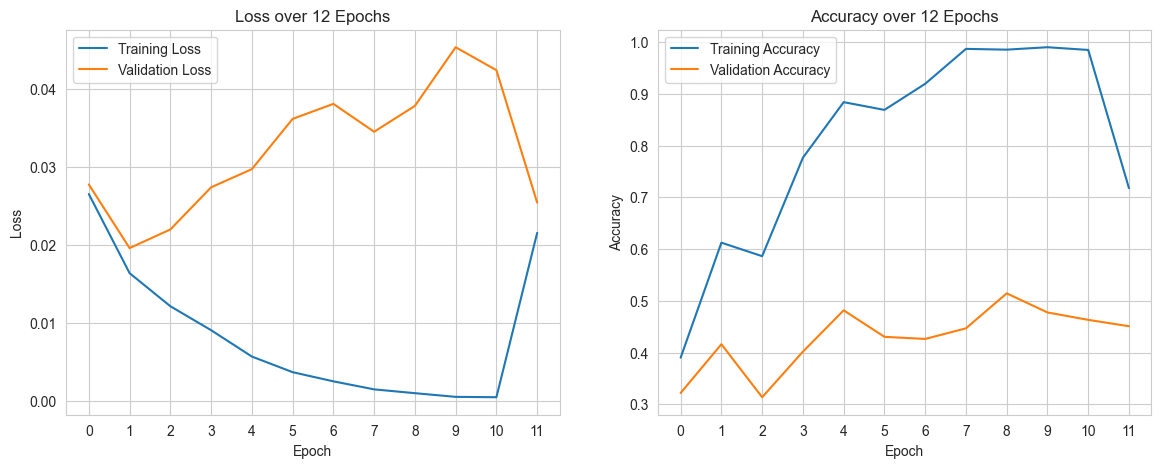

In [29]:
TrainLoopv2(model, optimizer, criterion, train_loader, val_loader, num_epochs=50, early_stopping_rounds=10, device="cuda")